<br><br>
<p style="font-size:24px; color:#216594;text-align:center;">
Applied AI in Chemical and Process Engineering
</p>

<p style="font-size:25px; color:black;text-align:center;">
    From Noise to Insight: Monitoring Catalyst Health Without Labels
</p>

<p style="font-size:20px; color:black;text-align:center;font-weight:bold;">
How PCA and K-Means turn raw sensors into an early warning system.
</p>


████████████████████████████████████████████████████████████████████
<br>

<p style="font-size:20px; color:black;text-align:left;">
    Problem: Catalyst Health
</p>

Catalyst degrade silently over time due to: 

- Deactivation (loss of active sites)
- Fouling (pore blockage by deposits)
- Poisoning (impurities killing sites)
     

| Impact                  | Consequences                          |
|-------------------------|---------------------------------------|
| Falling conversion      | Lost product, lower revenue           |
| Increased by products    | Poor quality, purification costs      |
| Higher energy use       | More heating/cooling needed           |
| Unplanned shutdowns     | $10k–$100k/hour in downtime           |
| Premature replacement   | Wasted catalyst, high cost            |

<p style="font-size:20px; color:black;text-align:left;">
    The Challenge: No Direct Measurement 
</p>

There is no **sensor** for "catalyst health". 

Instead, we see only indirect clues in: 

    Temperature profiles
    Conversion rates
    Pressure drops
    Gas composition
     
These signals are: 

    ✅ Continuous
    ❌ Noisy
    ❌ Multivariate
    ❌ Subtle — especially early on


<p style="font-size:20px; color:black;text-align:left;">
    Our Approach: Turn Data Into Insight
</p>
 

We use unsupervised learning to: 

- Discover hidden operating states in sensor data
- Detect subtle, multivariate shifts — long before alarms go off
- Automate monitoring across reactors and shifts


In This Exercise, You Will: 
- Apply PCA to uncover hidden patterns in catalyst degredation 
- Use clustering to separate normal vs. degraded states
- Build a live dashboard that monitors catalyst health
     

# Dataset

This dataset simulates 180 days of operation from a catalytic fixed-bed reactor used in processes like: 

- Hydrogenation
- Dehydrogenation
- Methanation
- Emissions control (e.g., CO oxidation)
     

<img src="./assets/catalyst_health.png" alt="Catalyst Health" width="500" height="auto">

| Sensor | Unit | Location | Purpose | Behavior During Degradation |
|--------|------|----------|---------|------------------------------|
| `T_inlet` | °C | Reactor inlet | Feed temperature baseline | Slight increase (operator compensation) |
| `T_midbed` | °C | Middle of catalyst bed | Measures peak reaction heat | **Decreases** (less exothermic reaction) |
| `T_outlet` | °C | Reactor outlet | Exit temperature | Slight decrease |
| `T_jacket_in` | °C | Cooling jacket inlet | Coolant input temp | Stable |
| `T_jacket_out` | °C | Cooling jacket outlet | Coolant output temp | **Decreases** (less heat to remove) |
| `Flow_rate` | L/min | Inlet/Outlet | Reactant throughput | May drop slightly |
| `Pressure_drop` | bar | Across catalyst bed | ΔP indicates blockage | **Increases** (fouling) |
| `Conversion` | % | Outlet (calculated) | % reactant → product | **Gradually decreases** (key sign) |
| `CO_ratio` | – | Outlet gas analyzer | Byproduct ratio | **Increases** (side reactions) |
| `H2_utilization` | % | Gas balance | Hydrogen consumption | **Decreases** (lost active sites) |

# Libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns

# Data

In [11]:
#data=pd.read_csv('./data/catalyst_health.csv')
data=pd.read_csv('https://raw.githubusercontent.com/dissabnd/Applied-AI-in-Chemical-and-Process-Engineering/refs/heads/main/data/catalyst_health.csv')

data

,Unnamed: 0,Day,T_inlet,T_midbed,T_outlet,T_jacket_in,T_jacket_out,Flow_rate,Pressure_drop,Conversion,CO_ratio,H2_utilization
0,0,0,299.295072,340.681953,334.066478,279.222597,289.334116,96.935586,1.052856,90.383448,0.459622,94.876296
1,1,1,299.710145,339.661800,334.828695,281.226589,290.377132,96.339063,1.120647,90.811717,0.529454,95.835241
2,2,2,300.732165,340.268300,334.211944,280.654975,289.558222,100.561130,1.043760,93.395804,0.482306,96.406358
3,3,3,298.892222,339.786058,333.755480,280.890089,290.506345,102.617746,1.253512,91.144688,0.480749,96.116384
4,4,4,300.204714,340.063476,335.833560,280.505170,290.162338,104.209819,1.018209,90.716891,0.505416,96.449152
...,...,...,...,...,...,...,...,...,...,...,...,...
175,175,175,300.988899,340.013464,333.133949,279.611166,288.665133,98.267737,1.111219,89.321668,0.534545,94.273845
176,176,176,300.742875,335.161167,334.691581,279.553829,290.319378,98.203982,1.437585,88.419309,0.542643,90.648260
177,177,177,300.732159,337.655476,334.665703,280.832312,290.517757,102.237311,1.168887,89.185510,0.472033,93.718054
178,178,178,301.174931,336.551057,333.733239,280.994353,289.613451,99.262626,1.273310,88.582062,0.572445,93.402255


## Visualization

-------------------------------
Plot Raw Data – Can You See the Drift?
-------------------------------

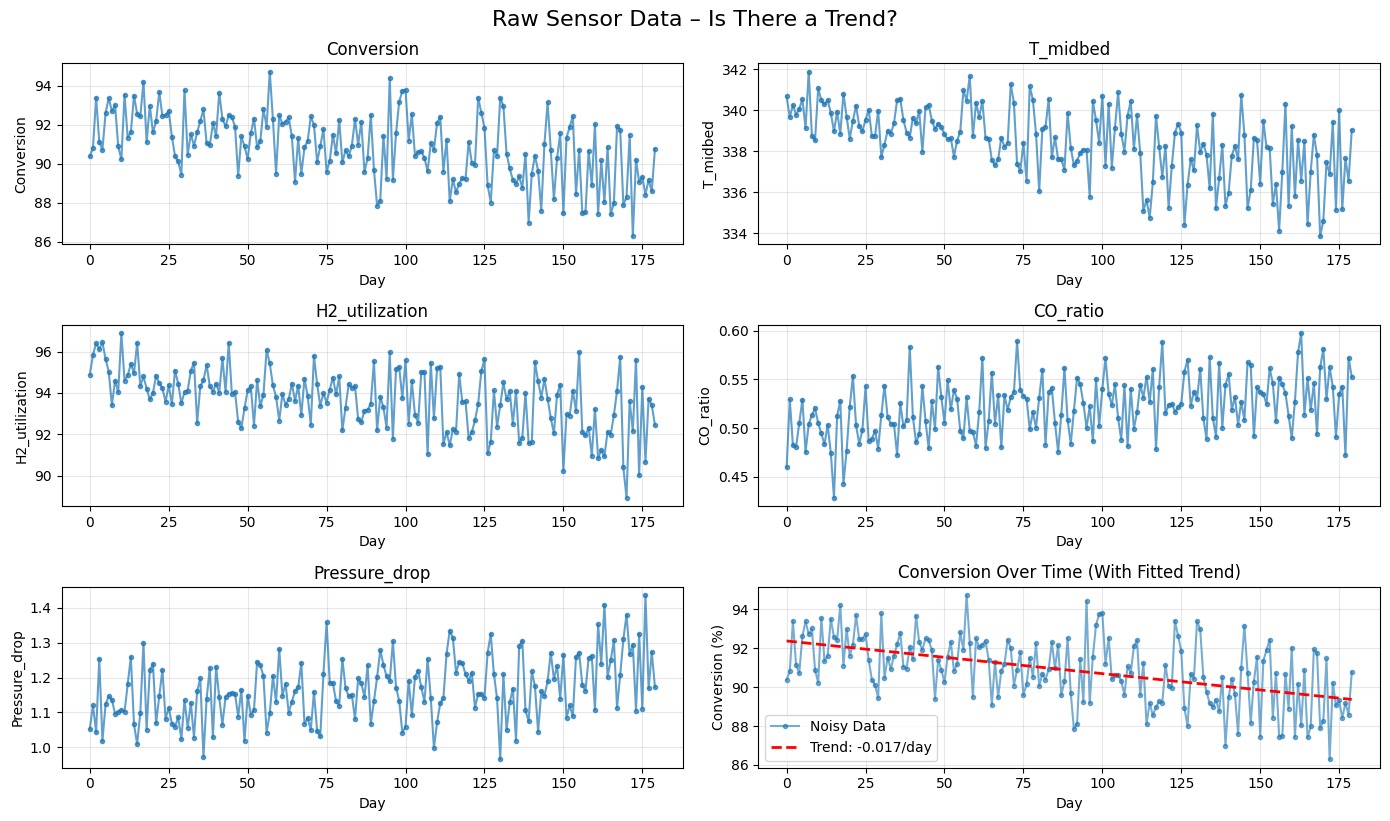

In [3]:
features = ['Conversion', 'T_midbed', 'H2_utilization', 'CO_ratio', 'Pressure_drop']

plt.figure(figsize=(14, 8))
for i, col in enumerate(features):
    plt.subplot(3, 2, i+1)
    plt.plot(data['Day'], data[col], 'o-', markersize=3, alpha=0.7)
    plt.title(f'{col}')
    plt.ylabel(col)
    plt.xlabel('Day')
    plt.grid(True, alpha=0.3)

# Subplot 6: Conversion with trend line
plt.subplot(3, 2, 6)
plt.plot(data['Day'], data['Conversion'], 'o-', markersize=3, alpha=0.6, label='Noisy Data')
z = np.polyfit(data['Day'], data['Conversion'], 1)
p = np.poly1d(z)
plt.plot(data['Day'], p(data['Day']), 'r--', linewidth=2, label=f'Trend: {z[0]:.3f}/day')
plt.title('Conversion Over Time (With Fitted Trend)')
plt.ylabel('Conversion (%)')
plt.xlabel('Day')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Raw Sensor Data – Is There a Trend?', y=1.02, fontsize=16)
plt.show()

# PCA and Clustering

In [4]:
sensor_cols = [
    'T_inlet', 'T_midbed', 'T_outlet',
    'T_jacket_in', 'T_jacket_out',
    'Flow_rate', 'Pressure_drop',
    'Conversion', 'CO_ratio', 'H2_utilization'
]

X = data[sensor_cols].copy()

# Pipeline: Scale → PCA → KMeans
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)),
    ('kmeans', KMeans(n_clusters=2, random_state=42, n_init=10))
])

# Fit and assign clusters
data['Cluster'] = pipeline.fit_predict(X)

# Extract fitted components
pca = pipeline.named_steps['pca']
scaler = pipeline.named_steps['scaler']
X_scaled = scaler.transform(X)
pca_scores = pca.transform(X_scaled)  # Shape: (n_samples, 5)

# Add PCA scores to data
for i in range(5):
    data[f'PC{i+1}'] = pca_scores[:, i]

# Explained variance
explained = pca.explained_variance_ratio_
cumulative = np.cumsum(explained)
print(f"PCA: {cumulative[-1]:.1%} of variance explained by 5 components")

PCA: 73.0% of variance explained by 5 components


## PCA Loading

In [5]:
# Loadings = Feature contributions to each PC
loadings = pd.DataFrame(
    pca.components_.T,  # Transpose: variables × components
    columns=[f'PC{i+1}' for i in range(5)],
    index=sensor_cols
)

# Round for readability
loadings = loadings.round(3)

# Optional: Save
# loadings.to_csv('pca_loadings.csv')

print("\nPCA Loadings (Feature Weights):")
print(loadings)


PCA Loadings (Feature Weights):
                  PC1    PC2    PC3    PC4    PC5
T_inlet        -0.051  0.681 -0.179 -0.292  0.185
T_midbed        0.496 -0.022 -0.019 -0.010  0.025
T_outlet       -0.060 -0.255  0.792 -0.113  0.049
T_jacket_in    -0.012  0.252  0.004  0.857 -0.255
T_jacket_out    0.119 -0.389 -0.321  0.246  0.746
Flow_rate       0.079  0.431  0.474  0.238  0.485
Pressure_drop  -0.414 -0.210  0.046  0.150  0.080
Conversion      0.446  0.044  0.077 -0.008  0.111
CO_ratio       -0.355  0.156  0.005 -0.142  0.278
H2_utilization  0.480 -0.012  0.071 -0.082 -0.098


# Visualize Results

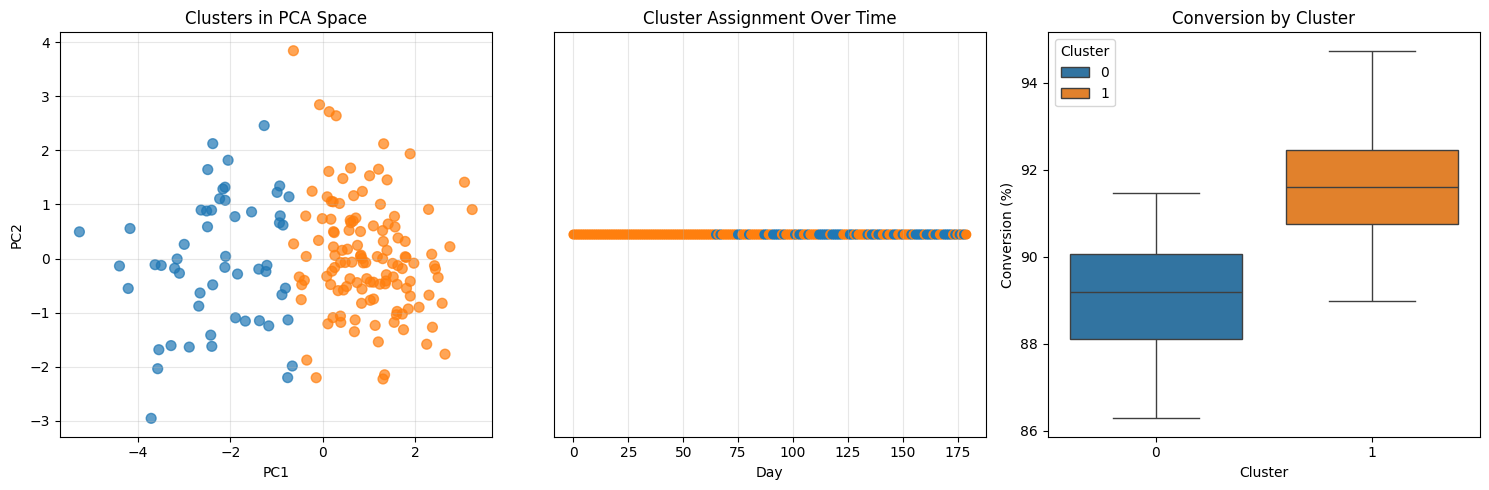

In [6]:
plt.figure(figsize=(15, 5))

# Subplot 1: PC1 vs PC2 colored by cluster
plt.subplot(1, 3, 1)
colors = ['tab:blue' if c == 0 else 'tab:orange' for c in data['Cluster']]
plt.scatter(data['PC1'], data['PC2'], c=colors, alpha=0.7, s=50)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters in PCA Space')
plt.grid(True, alpha=0.3)

# Subplot 2: Clusters over time
plt.subplot(1, 3, 2)
plt.scatter(data['Day'], [1]*len(data), c=colors, s=40)
plt.yticks([])
plt.xlabel('Day')
plt.title('Cluster Assignment Over Time')
plt.grid(True, alpha=0.3)

# Subplot 3: Conversion by cluster
plt.subplot(1, 3, 3)
sns.boxplot(data=data, x='Cluster', y='Conversion', hue='Cluster')
plt.title('Conversion by Cluster')
plt.ylabel('Conversion (%)')

plt.tight_layout()
plt.show()

# Interpret Clusters

## Cluster center

In [7]:
cluster_means = data.groupby('Cluster')[sensor_cols].mean().round(3)

print("Average Sensor Values by Cluster:")
print(cluster_means.T)

Average Sensor Values by Cluster:
Cluster               0        1
T_inlet         300.092  300.057
T_midbed        336.575  339.260
T_outlet        335.110  334.840
T_jacket_in     280.083  280.011
T_jacket_out    289.938  290.233
Flow_rate        99.767  100.352
Pressure_drop     1.247    1.129
Conversion       89.112   91.644
CO_ratio          0.544    0.512
H2_utilization   92.161   94.373


In [8]:
# Determine which cluster is "healthier"
if cluster_means.loc[0, 'Conversion'] > cluster_means.loc[1, 'Conversion']:
    normal_cluster = 0
    degraded_cluster = 1
else:
    normal_cluster = 1
    degraded_cluster = 0

# Now assign interpretations to the actual cluster numbers
interpretation = {}

# Assign correct label to each cluster ID
interpretation[normal_cluster] = (
    "✅ Normal Operation\n"
    "- High conversion\n"
    "- Stable temperatures\n"
    "- Low pressure drop"
)

interpretation[degraded_cluster] = (
    "⚠️ Degraded State\n"
    "- Falling conversion\n"
    "- Rising pressure drop\n"
    "- Signs of fouling or deactivation"
)

# Now print: Cluster X → its correct interpretation
print(f"\n🔍 Cluster Interpretation:")
for c in [0, 1]:
    print(f"Cluster {c}: {interpretation[c]}")


🔍 Cluster Interpretation:
Cluster 0: ⚠️ Degraded State
- Falling conversion
- Rising pressure drop
- Signs of fouling or deactivation
Cluster 1: ✅ Normal Operation
- High conversion
- Stable temperatures
- Low pressure drop


# Catalyst Health Score

In [9]:
# Weighted combination (PC1 dominates)
weights = [0.5, 0.2, 0.15, 0.1, 0.05]
composite = np.dot(pca_scores, weights)  # Direction depends on data

# Now check: does `composite` correlate with Conversion?
corr_with_conv = np.corrcoef(composite, data['Conversion'])[0, 1]

if corr_with_conv < 0:
    # composite ↑ = conversion ↓ → so flip it
    health_raw = -composite
else:
    # composite ↑ = conversion ↑ → good!
    health_raw = composite

# Now normalize: higher = healthier
health_min, health_max = health_raw.min(), health_raw.max()
data['Catalyst_Health_Index'] = 100 * (health_raw - health_min) / (health_max - health_min)
data['Catalyst_Health_Index_Smooth'] = data['Catalyst_Health_Index'].rolling(window=7, center=True).mean().fillna(method='ffill').fillna(method='bfill')

print ('corr with conversion:', corr_with_conv.round(2))

corr with conversion: 0.77


/var/folders/q6/089bql4s3m78jxrgfwv4dkxc0000gn/T/ipykernel_26847/1577578637.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Catalyst_Health_Index_Smooth'] = data['Catalyst_Health_Index'].rolling(window=7, center=True).mean().fillna(method='ffill').fillna(method='bfill')


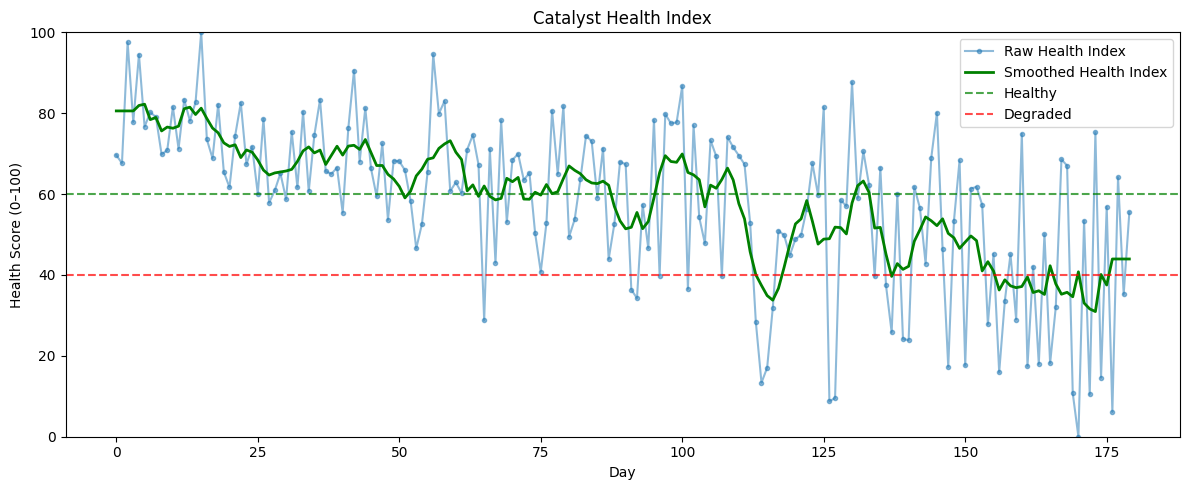

In [10]:
plt.figure(figsize=(12, 5))
colors = ['blue' if c == normal_cluster else 'red' for c in data['Cluster']]

plt.plot(data['Day'], data['Catalyst_Health_Index'], 'o-', markersize=3, alpha=0.5, label='Raw Health Index')
plt.plot(data['Day'], data['Catalyst_Health_Index_Smooth'], 'g-', linewidth=2, label='Smoothed Health Index')

plt.axhline(60, color='green', linestyle='--', alpha=0.7, label='Healthy')
plt.axhline(40, color='red', linestyle='--', alpha=0.7, label='Degraded')

plt.title('Catalyst Health Index')
plt.ylabel('Health Score (0–100)')
plt.xlabel('Day')
plt.legend()
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

We transformed PC1 into a simple 0–100% health score:

    >60%: Green — Normal  
    40–60%: Yellow — Degrading (investigate)  
    <40%: Red — Severe degradation (plan regeneration)
     

# Dashboard

<img src="./assets/catalyst_dashboard.png" alt="Dashborard" width="1000" height="auto">